In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
import testcases
from importlib import reload
import class_flp
import utils
import time
import pickle
import datetime

### Comparison at a given beta

In [179]:
# reload(testcases)
# reload(class_flp)

# # load/generate a testcase
# N = 1000
# M = 10
# d = 2
# # N, M, d, resLoc, Y0, res_means, split_pct, rho = testcases.testcase_catalog('small_tc_300_3')
# resLoc, Y0, res_means, split_pct, rho = testcases.generate_testcase(
#     N, M, d, unif_split=True, cluster_cov=10, seed=10, sq_size=20, normalizer=False)
# # allocation cost
# alloc_cost = np.random.uniform(100,150,(N,M))
# mean_alloc_cost = np.mean(alloc_cost)
# C = np.random.uniform(0.3,1,len(split_pct))
# # C = np.ones(shape=split_pct.shape)
# C = (C/np.sum(C) + 1e-5) * mean_alloc_cost
# B = np.random.uniform(0.0, C.min()*0.7, len(split_pct))

# # initialize FLP class
# flp = class_flp.FLP(N, M, d, resLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)

# # initialize state
# Y0 = np.random.uniform(10,20,(flp.M, flp.d))
# P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
# P0 = P0/P0.sum(axis=1,keepdims=True)
# x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

# class_flp.plot_flp(flp, res_means, np.expand_dims(Y0,axis=0), np.expand_dims(P0,axis=0),figSize=(10,8))
# print(f'rho shape: {rho.shape}')
# print(f'cluster split: {split_pct}')
# print(f'upper allocation cost limit: {C}')
# print(f'lower allocation cost limit: {B}')
# centroid = np.sum(rho*resLoc, axis=0)
# print(f'centroid:{centroid}')


In [180]:
# # Setting the coefficients for CBF CLF based optimization
# alpha_h = 20
# alpha_l = 20
# p = 1
# gamma = 20
# u_b = 0.0

# # SGF
# alpha = 1
# kappa = 1

# T_f = 20
# dt_init = 0.1
# dt_max = 0.1
# dt_min = 1e-4
# Ftol = 0.01 # same for SLSQP and SGF
# xtol = 1e-3

# # annealing parameters
# beta0 = 1e-3
# # betaf = 1e2
# # beta_grow = 2


### Compare methods at fixed beta for fixed scenario

In [181]:
# # Setting the coefficients for CBF CLF based optimization
# alpha_h = 20
# alpha_l = 20
# p = 1
# gamma = 20
# u_b = 0.0

# x1, F1 = flp.optimize_CBF_CLF(x0, beta0, p, gamma, alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True)
# print(f'cost:{F1:.6f}')

In [182]:
# reload(class_flp)
# Y_arr_cbf = np.array([utils.x2Y(flp.M, x0), utils.x2Y(flp.M, x1)])
# P_arr_cbf = np.array([utils.x2Y(flp.M, x0), utils.x2P(flp.M, x1)])
# class_flp.plot_flp(flp, res_means, Y_arr_cbf, P_arr_cbf, figSize=(10,8))

In [183]:
# x2, F2 = flp.optimize_SLSQP(x0, beta0, ftol=1e-2)
# print(f'cost:{F2:.6f}')


In [184]:
# reload(class_flp)
# Y_arr_slsqp = np.array([utils.x2Y(flp.M, x0), utils.x2Y(flp.M, x2)])
# P_arr_slsqp = np.array([utils.x2Y(flp.M, x0), utils.x2P(flp.M, x2)])
# class_flp.plot_flp(flp, res_means, Y_arr_slsqp, P_arr_slsqp, figSize=(10,8))

In [185]:
# x3, F3 = flp.optimize_SGF(x0, beta0, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True)

In [186]:
# reload(class_flp)
# Y_arr_sgf = np.array([utils.x2Y(flp.M, x0), utils.x2Y(flp.M, x3)])
# P_arr_sgf = np.array([utils.x2Y(flp.M, x0), utils.x2P(flp.M, x3)])
# class_flp.plot_flp(flp, res_means, Y_arr_sgf, P_arr_sgf, figSize=(10,8))

### Compare methods at different increasing values of N,M at fixed beta

In [187]:
reload(class_flp)
n_testcases = 6
list_N = [100*(i+1) for i in range(n_testcases)]
list_M = [int(2+0.7*i) for i in range(n_testcases)]
size_array = list(zip(list_N, list_M))
# size_array = list(zip(range(50, 251, 50), range(3, 6)))
beta0 = 1
d = 2
N_init_cond = 1
print(f'beta: {beta0}')

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10.0
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.01 # same for SLSQP and SGF
xtol = 1e-3


beta: 1


In [188]:
reload(class_flp)
reload(utils)
# storage arrays
t_cbf = np.zeros((N_init_cond, len(size_array)))
F_cbf = np.zeros((N_init_cond, len(size_array)))

t_slsqp = np.zeros((N_init_cond, len(size_array)))
F_slsqp = np.zeros((N_init_cond, len(size_array)))

t_sgf = np.zeros((N_init_cond, len(size_array)))
F_sgf = np.zeros((N_init_cond, len(size_array)))

for k in range(N_init_cond):
    print(f'Instance {k}\n')
    for i, (N,M) in enumerate(size_array):

        resLoc, Y0, res_means, split_pct, rho = utils.generate_testcase(
            N, M, d, unif_split=True, cluster_cov=10, seed=k, sq_size=20, normalizer=False)
        # allocation cost
        np.random.seed(k)
        alloc_cost = np.random.uniform(100,200,(N,M))
        mean_alloc_cost = np.mean(alloc_cost)
        C = np.random.uniform(0.3,1,len(split_pct))
        # C = np.ones(shape=split_pct.shape)
        C = (C/np.sum(C) + 0.02) * mean_alloc_cost
        B = np.random.uniform(C.min()*0.2, C.min()*0.5, len(split_pct))

        # initialize FLP class
        flp = class_flp.FLP(N, M, d, resLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)

        # initialize state
        Y0 = np.random.uniform(10,20,(flp.M, flp.d))
        P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
        P0 = P0/P0.sum(axis=1,keepdims=True)
        x0 = utils.YP2x(Y0, P0)

        print(f'\titer {i}\tsize: ({N,M})\tx0_shape: {x0.shape}')
        
        # CLF_CBF optimization
        t0 = time.time()
        x1, F1 = flp.optimize_CBF_CLF(x0, beta0, p1, p2, gamma, alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=False)
        t1 = time.time()
        t_cbf[k,i] = t1-t0
        F_cbf[k,i] = F1
        print(f'\t\tCBF cost: {F1:.3f}\ttime: {t_cbf[k,i]:.3f}')
        
        # SLSQP optimization
        t2 = time.time()
        x2, F2 = flp.optimize_SLSQP(x0, beta0, ftol=Ftol)
        t3 = time.time()
        t_slsqp[k,i] = t3-t2
        F_slsqp[k,i] = F2
        print(f'\t\tSLSQP cost: {F2:.3f}\ttime: {t_slsqp[k,i]:.3f}')

        # SGF optimization
        t4 = time.time()
        x3, F3 = flp.optimize_SGF(x0, beta0, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=False)
        t5 = time.time()
        t_sgf[k,i] = t5-t4
        F_sgf[k,i] = F3
        print(f'\t\tSGF cost: {F3:.3f}\ttime: {t_sgf[k,i]:.3f}')


Instance 0

	iter 0	size: ((100, 2))	x0_shape: (204,)


/Users/dhananjaytiwari/Library/Python/3.9/lib/python/site-packages/cvxpy/expressions/expression.py:497: FutureWarning: 
    You didn't specify the order of the flatten expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(flatten_order_warning, FutureWarning)


		CBF cost: 10.826	time: 0.354
		SLSQP cost: 10.840	time: 0.346
		SGF cost: 11.717	time: 2.170
	iter 1	size: ((200, 2))	x0_shape: (404,)
		CBF cost: 12.041	time: 0.566
		SLSQP cost: 12.077	time: 2.899
		SGF cost: 16.539	time: 4.278
	iter 2	size: ((300, 3))	x0_shape: (906,)
		CBF cost: 12.458	time: 1.141
		SLSQP cost: 12.322	time: 65.971
		SGF cost: 23.347	time: 14.752
	iter 3	size: ((400, 4))	x0_shape: (1608,)
		CBF cost: 10.279	time: 1.486
		SLSQP cost: 10.450	time: 356.689
		SGF cost: 22.954	time: 51.747
	iter 4	size: ((500, 4))	x0_shape: (2008,)
		CBF cost: 10.831	time: 3.654
		SLSQP cost: 12.159	time: 959.794
		SGF cost: 26.545	time: 81.757
	iter 5	size: ((600, 5))	x0_shape: (3010,)
		CBF cost: 11.529	time: 9.891
		SLSQP cost: 11.015	time: 5670.055
		SGF cost: 24.046	time: 170.833


In [202]:
# str(datetime.datetime.today()).split()
current_time = datetime.datetime.now()
yyyy = str(current_time.year)
mm = str(current_time.month)
dd = str(current_time.day)
hh = str(current_time.hour)
mt = str(current_time.minute)
sec = str(current_time.second)
current_datetime = yyyy + '_' + mm + '_' + dd + '_' + hh + '_' + mt + '_' + sec 

In [203]:
# save data
savedata = {'beta':beta0, 'size_array':size_array, 't_cbf':t_cbf, 't_sgf':t_sgf, 't_slsqp':t_slsqp, 
            'F_cbf':F_cbf, 'F_sgf':F_sgf, 'F_slsqp': F_slsqp}
filedir = 'Simulations_and_results/final_results/fix_beta_compare/'
if beta0 == 1e-3:
    filename = filedir + 'small_beta_' + current_datetime + '.pkl'
elif beta0 == 1:
    filename = filedir + 'medium_beta_' + current_datetime + '.pkl'
elif beta0 == 1e2:
    filename = filedir + 'large_beta_' + current_datetime + '.pkl' 

with open(filename, 'wb') as file:
    pickle.dump(savedata, file)

1.0
24.75884698604109
212.36171006594964
beta:1.00000e-03


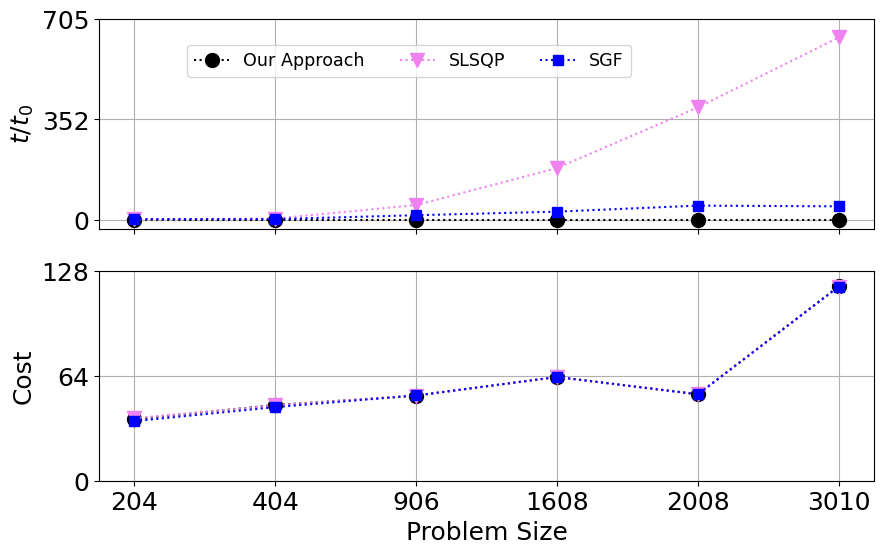

Simulations_and_results/final_results/fix_beta_compare/small_beta_2025_3_29_15_9_20.pdf
1.0
16.84770406362581
189.97484271193625
beta:1.00000e+00


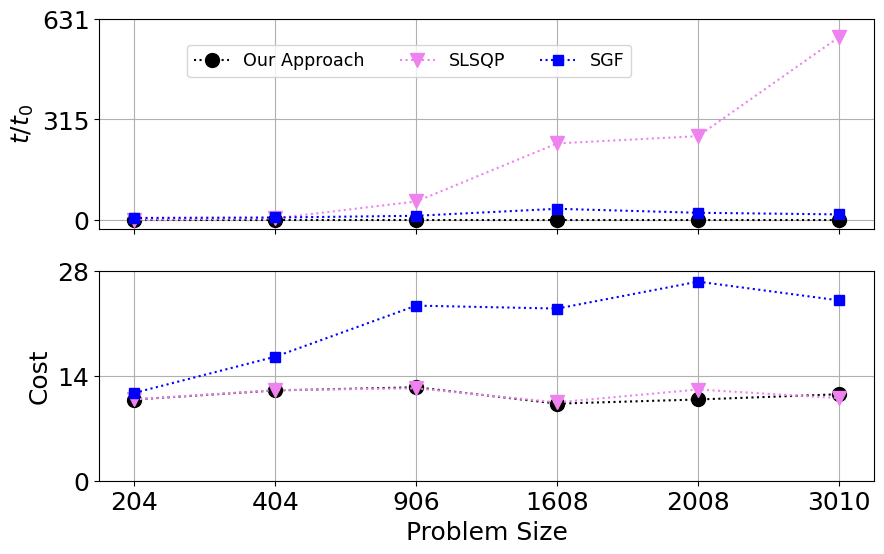

Simulations_and_results/final_results/fix_beta_compare/medium_beta_2025_3_29_22_54_37.pdf
1.0
28.368192151622974
323.22587814442966
beta:1.00000e+02


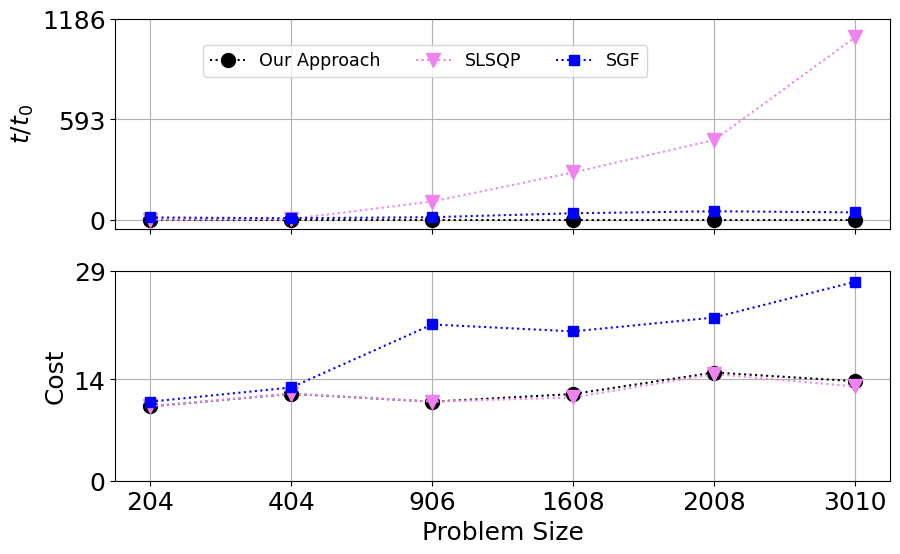

Simulations_and_results/final_results/fix_beta_compare/large_beta_compare_2025_3_24_13_59_4.pdf


In [6]:
filedir = 'Simulations_and_results/final_results/fix_beta_compare/'
# beta_rb = 1e2
# if beta_rb == 1e-3:
filename0 = filedir + 'small_beta_2025_3_29_15_9_20.pkl'
# elif beta_rb == 1:
filename1 = filedir + 'medium_beta_2025_3_29_22_54_37.pkl'
# elif beta_rb == 1e2:
filename2 = filedir + 'large_beta_compare_2025_3_24_13_59_4.pkl'

filenames_list = [filename0, filename1, filename2]

for i, filenameX in enumerate(filenames_list):
    filename = filenameX
    with open(filename, 'rb') as file:
        loaddata = pickle.load(file)

    t1_cbf = loaddata['t_cbf']
    t1_sgf = loaddata['t_sgf']
    t1_slsqp = loaddata['t_slsqp']
    F1_cbf = loaddata['F_cbf']
    F1_sgf = loaddata['F_sgf']
    F1_slsqp = loaddata['F_slsqp']
    size_array = loaddata['size_array']
    beta_rb = loaddata['beta']

    # Compute average values
    m_t_cbf = np.mean(t1_cbf, axis=0)
    m_t_sgf = np.mean(t1_sgf, axis=0)
    m_t_slsqp = np.mean(t1_slsqp, axis=0)
    m_F_cbf = np.mean(F1_cbf, axis=0)
    m_F_sgf = np.mean(F1_sgf, axis=0)
    m_F_slsqp = np.mean(F1_slsqp, axis=0)
    
    # compute rescaled time values
    norm_m_t_cbf = m_t_cbf/m_t_cbf
    norm_m_t_sgf = m_t_sgf/m_t_cbf
    norm_m_t_slsqp = m_t_slsqp/m_t_cbf

    print(np.mean(norm_m_t_cbf))
    print(np.mean(norm_m_t_sgf))
    print(np.mean(norm_m_t_slsqp))

    fontSize = 18
    clr = {'our':'black', 'SGF':'blue', 'SLSQP':'violet'}
    mk = {'our':'o', 'SGF':'s', 'SLSQP':'v'}
    mks = {'our':10, 'SGF':7, 'SLSQP':10}
    lb = {'our':'Our Approach', 'SGF':'SGF', 'SLSQP':'SLSQP'}

    print(f'beta:{beta_rb:.5e}')
    plt.figure(figsize=(10, 6))

    plt.subplot(2,1,1)
    plt.plot(range(len(size_array)), norm_m_t_cbf, color=clr['our'], marker=mk['our'], markersize=mks['our'], label=lb['our'], linestyle='dotted')  # Plot F with blue circles
    plt.plot(range(len(size_array)), norm_m_t_slsqp, color=clr['SLSQP'], marker=mk['SLSQP'], markersize=mks['SLSQP'], label=lb['SLSQP'], linestyle='dotted')  # Plot G with red circles
    plt.plot(range(len(size_array)), norm_m_t_sgf, color=clr['SGF'], marker=mk['SGF'], markersize=mks['SGF'], label=lb['SGF'], linestyle='dotted')  # Plot G with red circles

    # plt.xlabel("Problem Size (N,M)")
    plt.ylabel(rf"$t/t_0$", fontsize=fontSize)
    plt.xticks(range(len(size_array)), [f" " for n, m in size_array], rotation=0)  # Set x-axis labels as (N, M)
    ymin_t, ymax_t = plt.ylim()
    yticks = [int(y) for y in np.linspace(0.0, ymax_t*(1+0.05), 3)]
    plt.yticks(yticks, fontsize=fontSize)
    # plt.title(rf"Computation time comparison at $\beta={beta0:.3e}$")
    plt.legend(fontsize=fontSize*0.7, ncol=3, loc="center", bbox_to_anchor=(0.4, 0.8))
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(range(len(size_array)), m_F_cbf,color=clr['our'], marker=mk['our'], markersize=mks['our'], label=lb['our'], linestyle='dotted')  # Plot F with blue circles
    plt.plot(range(len(size_array)), m_F_slsqp, color=clr['SLSQP'], marker=mk['SLSQP'], markersize=mks['SLSQP'], label=lb['SLSQP'], linestyle='dotted')  # Plot G with red circles
    plt.plot(range(len(size_array)), m_F_sgf, color=clr['SGF'], marker=mk['SGF'], markersize=mks['SGF'], label=lb['SGF'], linestyle='dotted')  # Plot F with blue circles
    plt.xlabel("Problem Size", fontsize=fontSize)
    plt.ylabel(rf"Cost", fontsize=fontSize)
    plt.xticks(range(len(size_array)), [f"{n*m + 2*m}" for n, m in size_array], rotation=0, fontsize=fontSize)  # Set x-axis labels as (N, M)
    ymin_t, ymax_t = plt.ylim()
    yticks = [int(y) for y in np.linspace(0.0, ymax_t*(1+0.05), 3)]
    plt.yticks(yticks, fontsize=fontSize)
    # if i == len(filenameX)-1:
    # plt.legend(fontsize=fontSize*0.7, ncol=3, loc="left", bbox_to_anchor=(0.5, 0.7))
    plt.grid(True)

    filename_pdf = filename[:-3] + 'pdf'
    plt.savefig(filename_pdf, format="pdf")
    plt.show()

    print(filename_pdf)
